In [1]:
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [2]:
# Load the two NIfTI images
T1_path = 'data/T1.nii'
T2_path = 'data/T2_FLAIR.nii'
label_path = 'data/Labels.nii'

### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [3]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

Iteration:  0  --- Log Likelihood:  789878.3614758974  --- Time (s):  17.674837827682495


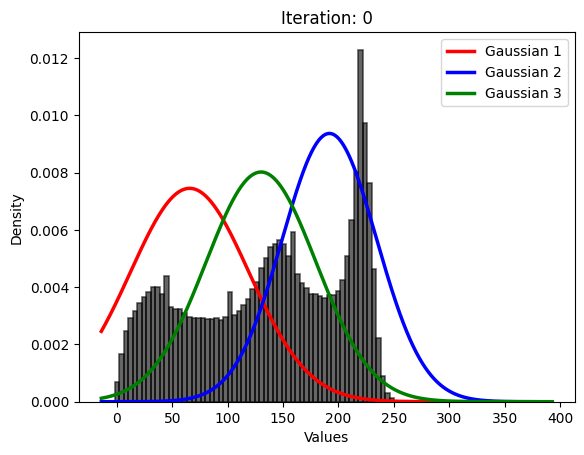

Iteration:  1  --- Log Likelihood:  911741.117714354  --- Time (s):  18.057425022125244
Iteration:  2  --- Log Likelihood:  974398.3746949525  --- Time (s):  18.208941221237183
Iteration:  3  --- Log Likelihood:  994582.2743414345  --- Time (s):  17.883754014968872
Iteration:  4  --- Log Likelihood:  1000751.2593910139  --- Time (s):  17.56322193145752
Iteration:  5  --- Log Likelihood:  1002799.4435953889  --- Time (s):  17.741469383239746
Iteration:  6  --- Log Likelihood:  1003728.578585063  --- Time (s):  17.60161781311035
Iteration:  7  --- Log Likelihood:  1004468.791477015  --- Time (s):  18.188668251037598
Iteration:  8  --- Log Likelihood:  1005346.1584133477  --- Time (s):  17.408236980438232
Iteration:  9  --- Log Likelihood:  1006515.0248503839  --- Time (s):  17.35824704170227
Iteration:  10  --- Log Likelihood:  1008092.8810092431  --- Time (s):  17.38164782524109
Iteration:  11  --- Log Likelihood:  1010210.8369396924  --- Time (s):  18.74205708503723
Iteration:  12  ---

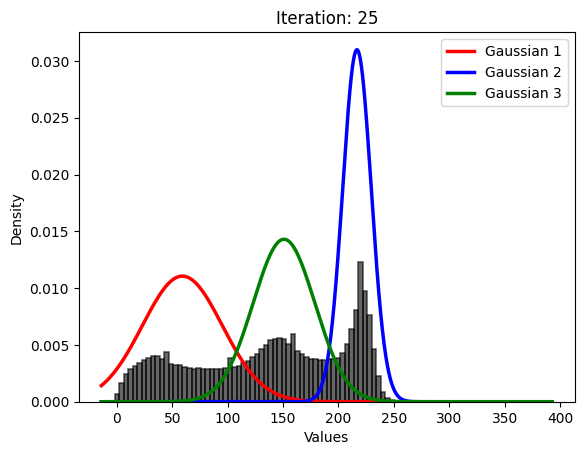

Iteration:  26  --- Log Likelihood:  1072899.7036175216  --- Time (s):  17.636866092681885
Iteration:  27  --- Log Likelihood:  1075284.2653290816  --- Time (s):  17.572870016098022
Iteration:  28  --- Log Likelihood:  1077330.0232593308  --- Time (s):  17.611905097961426
Iteration:  29  --- Log Likelihood:  1079063.4274533459  --- Time (s):  17.57147789001465
Iteration:  30  --- Log Likelihood:  1080516.305748492  --- Time (s):  17.68865203857422
Iteration:  31  --- Log Likelihood:  1081723.1535792097  --- Time (s):  17.98069477081299
Iteration:  32  --- Log Likelihood:  1082718.6801907835  --- Time (s):  17.620469093322754
Iteration:  33  --- Log Likelihood:  1083535.831236547  --- Time (s):  17.556790113449097
Iteration:  34  --- Log Likelihood:  1084204.4806356058  --- Time (s):  17.685798168182373
Iteration:  35  --- Log Likelihood:  1084750.7834916865  --- Time (s):  18.030047178268433
Iteration:  36  --- Log Likelihood:  1085197.0414645192  --- Time (s):  17.79558515548706
Itera

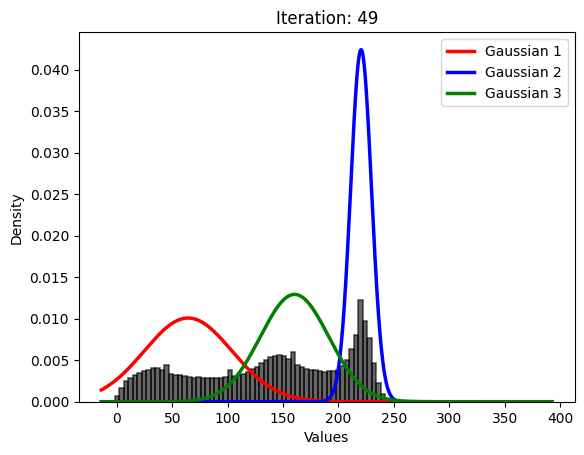

In [4]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path='results/', show_plot=True, stop_criterion=1e-4)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [5]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [6]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == 1)
class2_idx = np.where(segmented_image == 2)
class3_idx = np.where(segmented_image == 3)
segmented_image[class1_idx] = sorted_mean_indices[0]
segmented_image[class2_idx] = sorted_mean_indices[1]
segmented_image[class3_idx] = sorted_mean_indices[2]

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, 'results/segmented_brain.nii')

print("Segmented brain image saved as 'results/segmented_brain.nii'")

Segmented brain image saved as 'results/segmented_brain.nii'


## Evaluation

In [7]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, 'results/segmented_brain.nii')    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.9068793161732748, 2: 0.8227203274919518, 3: 0.8513946908581953}
Average Dice Score:  0.8603314448411407
